In [1]:
from glob import iglob
from datetime import datetime
from itertools import chain, repeat
from functools import reduce, partial

import numpy as np
import pandas as pd
from cytoolz import compose, reduce
from h5py import File
from dask import delayed, compute
from dask.bag import from_sequence
from dask.diagnostics import ProgressBar
import matplotlib.pyplot as plt
from numba import jit

In [2]:
def is_available(filename):
    try:
        with File(filename, 'r'):
            pass
        return True
    except Exception:
        return False


def read_scala(filename, tag_offset = None):
    if tag_offset is None:
        where = slice(None)
    else:
        where = slice(tag_offset, None)
    with File(filename, 'r') as f:
        try:
            for tag, iom, img, dt in zip(
                f['/bunches'][where],
                f['/photon_diagnostics/FEL01/I0_monitor/iom_sh_a_pc'][where],
                f['/vmi/andor'],
                f['/user_laser/delay_line/position'][where],
            ):
                yield {
                    'tag': tag,
                    'iom_intensity_pc': iom,
                    'img_intensity': img.sum(),
                    'delay_float': dt,
                }
        except KeyError:
            return

In [3]:
run = 219
tag_offset = 0  # 0 or 1
filenames = sorted(fn for fn in set(iglob(f"/data/*/Run_{run:03d}/rawdata/*.h5")))
print(f"Total {len(filenames)} files:")
for fn in filenames[:5]:
    print(f"    {fn}")
print("    ...")

Total 520 files:
    /data/Step501N2/Run_219/rawdata/Run_219_487233077.h5
    /data/Step501N2/Run_219/rawdata/Run_219_487233177.h5
    /data/Step501N2/Run_219/rawdata/Run_219_487233277.h5
    /data/Step501N2/Run_219/rawdata/Run_219_487233377.h5
    /data/Step501N2/Run_219/rawdata/Run_219_487233477.h5
    ...


In [4]:
with ProgressBar():
    df = (
        from_sequence(filenames)
        .topk(10)
        .map(read_scala, tag_offset=tag_offset)
        .flatten()
        .to_dataframe()
        .compute()
    )
df.head()

[########################################] | 100% Completed |  0.4s
[########################################] | 100% Completed | 22.0s


,delay_float,img_intensity,iom_intensity_pc,tag
0,-6.099971,281147695,11.882401,487289173
1,-6.099971,269753339,11.657524,487289174
2,-6.099971,213160399,11.496162,487289175
3,-6.099971,346693614,12.048912,487289176
4,-6.099971,324884776,11.956215,487289177


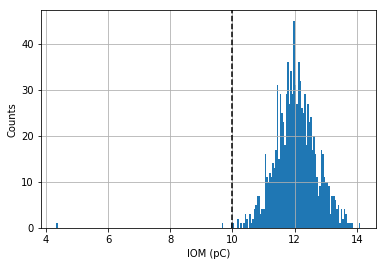

In [ ]:
iom_limit = 10

plt.figure()
plt.hist(df["iom_intensity_pc"], bins=200)
plt.axvline(iom_limit, color='k', linestyle='--')
plt.xlabel("IOM (pC)")
plt.ylabel("Counts")
plt.grid(True)
plt.show()

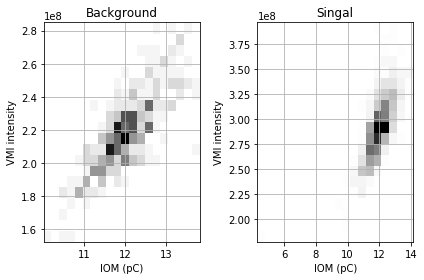

In [ ]:
bg_period, bg_mod = 3, 0  # Confirm this parameters!
df["is_bg"] = df["tag"] % bg_period == bg_mod

plt.figure()
plt.subplot(121)
where = df["is_bg"]
plt.hist2d(df[where]["iom_intensity_pc"],
           df[where]["img_intensity"], bins=[20, 20], cmap="Greys")
plt.title("Background")
plt.xlabel("IOM (pC)")
plt.ylabel("VMI intensity")
plt.grid(True)

plt.subplot(122)
where = ~df["is_bg"]
plt.hist2d(df[where]["iom_intensity_pc"],
           df[where]["img_intensity"], bins=[20, 20], cmap="Greys")
plt.title("Singal")
plt.xlabel("IOM (pC)")
plt.ylabel("VMI intensity")
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
def read_img(filename, tag_offset = None):
    if tag_offset is None:
        where = slice(None)
    else:
        where = slice(tag_offset, None)

    with File(filename, 'r') as f:
        try:
            for tag, img, iom, dt, y in zip(
                f['/bunches'][where],
                f['/vmi/andor'],
                f['/photon_diagnostics/FEL01/I0_monitor/iom_sh_a_pc'][where],
                f['/user_laser/delay_line/position'][where],
                f["/photon_diagnostics/Spectrometer/hor_spectrum"][where],
            ):
                yield {
                    'tag': tag,
                    'img': img.astype('double'),
                    'iom': iom,
                    'delay_float': dt,
                    'atmax_float': y.argmax(),
                }
        except KeyError:
            return
        

@jit
def bin_delays(d):
    step = 0.02  # Check delay step!
    centers = np.arange(-10, 0, step)
    bins = (centers[1:] + centers[:-1]) / 2
    return centers.item(np.digitize(d, bins=bins))


@jit
def bin_atmax(d):
    step = 5  # Check delay step!
    centers = np.arange(0, 1000, step)
    bins = (centers[1:] + centers[:-1]) / 2
    return centers.item(np.digitize(d, bins=bins))


@jit
def sumup_images(it):
    df = pd.DataFrame(list(it))
    where = iom_limit < df['iom']
    df['delay'] = df['delay_float'].apply(bin_delays)
    df['atmax'] = df['atmax_float'].apply(bin_atmax)
    df["is_bg"] = df["tag"] % bg_period == bg_mod
    grouped = df[where].groupby(['is_bg', 'delay', 'atmax'])['img']
    return pd.DataFrame({
        'sum': grouped.apply(sum),
        'count': grouped.count(),
    })

In [ ]:
reduced = partial(reduce, partial(pd.DataFrame.add, fill_value=0))

with ProgressBar():
    summed = (
        from_sequence(filenames)
        .map(read_img, tag_offset=tag_offset)
        .flatten()
        .reduction(sumup_images, reduced)
        .compute()
    )
summed

[####################################### ] | 99% Completed | 37min 31.0s

In [ ]:
avg = summed['sum'] / summed['count']
diff = avg.loc[False] - avg.loc[True]
    
for (dt, atmax), img in diff.items():
    if np.isnan(img).any():
        continue
    plt.figure(figsize=(15, 5))
    plt.subplot(131)
    plt.title("Background")
    plt.pcolormesh(avg.loc[True, dt, atmax], cmap="Greys")
    plt.clim(0, None)
    plt.axis('equal')
    plt.subplot(132)
    plt.title("Signal")
    plt.pcolormesh(avg.loc[False, dt, atmax], cmap="Greys")
    plt.clim(0, None)
    plt.axis('equal')
    plt.subplot(133)
    plt.title("Diff")
    plt.pcolormesh(img, cmap="Greys")
    plt.clim(0, None)
    plt.axis('equal')
    plt.tight_layout()
    plt.show()
    break

In [ ]:
writein = f"/data/Step501N2/Run_{run:03d}/work"
summed.to_pickle(f"{writein}/reduced.pickle")
for (bg, dt, atmax), img, n in summed[['sum', 'count']].itertuples():
    ofn = f"{writein}/reduced_{('bg' if bg else 'sg')},dt={dt:.3f},atmax={atmax:d}.h5"
    print(ofn)
    with File(ofn, "w") as f:
        f['is_bg'] = bg
        f['delay'] = dt
        f['n'] = n
        f['img'] = img